### 지금 필요한 Llamagen 파일들: (for running VQVAE Model purposes)
1. tokenizer/tokenizer_image/vq_model.py
2. dataset/augmentation.py (for "crop" operation)
3. pretrained_models/

In [1]:
import torch
import torch.nn.functional as F

import numpy as np
from PIL import Image

from tokenizer.tokenizer_image.vq_model import VQ_models
from dataset.augmentation import center_crop_arr

In [2]:
import invops
from invops.aug.mix import OperationTree

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.get_device_name()

'NVIDIA TITAN Xp'

In [5]:
image_path = "assets/newyork.jpg"
output_dir = "output_vq_demo" #don't need this for visualization
suffix = "tokenizer_image" 
vq_model = "VQ-16" # 16*16 tokens
vq_ckpt = "pretrained_models/vq_ds16_c2i.pt" # pretrained VQVAE Model
codebook_size = 16384
codebook_embed_dim = 8
image_size = 512
seed = 0


In [6]:
#Model Setup
torch.manual_seed(0) #Set seed
torch.set_grad_enabled(False) #no grads needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VQ_models[vq_model](codebook_size = codebook_size
                            , codebook_embed_dim = codebook_embed_dim).to(device)
model.to(device)
model.eval()

checkpoint = torch.load(vq_ckpt, map_location=device)
if "ema" in checkpoint:  # ema
    model_weight = checkpoint["ema"]
elif "model" in checkpoint:  # ddp
    model_weight = checkpoint["model"]
elif "state_dict" in checkpoint:
    model_weight = checkpoint["state_dict"]
else:
    raise Exception("please check model weight")
model.load_state_dict(model_weight)
del checkpoint

In [10]:
def VQVAE_Output(image_path):
    pil_image = Image.open(image_path).convert("RGB")
    img = center_crop_arr(pil_image, image_size) #size에 맞게 변형

    img = np.array(img)/255.0

    x = 2.0 * img - 1.0 #x is value between -1 and 1
    x = torch.tensor(x)
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)
    x_input = x.float().to("cuda")


    # inference
    with torch.no_grad():
        latent, _, [_, _, indices] = model.encode(x_input)
        output = model.decode_code(indices, latent.shape) # output value is between [-1, 1]

    # postprocess
    output = F.interpolate(output, size=[image_size, image_size], mode='bicubic').permute(0, 2, 3, 1)[0]
    sample = torch.clamp(127.5 * output + 128.0, 0, 255).to("cpu", dtype=torch.uint8).numpy()
    return sample


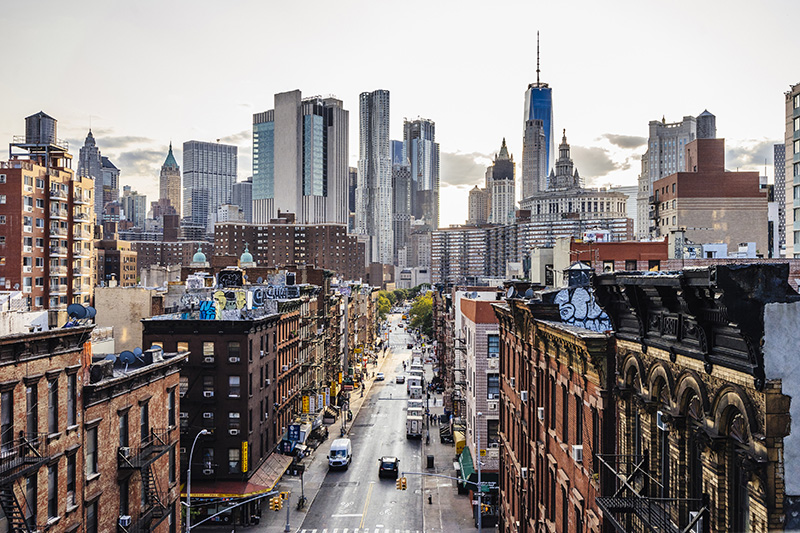

In [11]:
Image.open(image_path).convert("RGB")

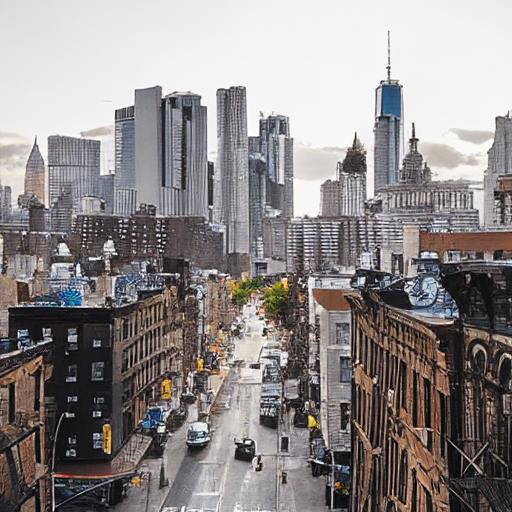

In [12]:
sample_image = Image.fromarray(VQVAE_Output(image_path = image_path))

display(sample_image)

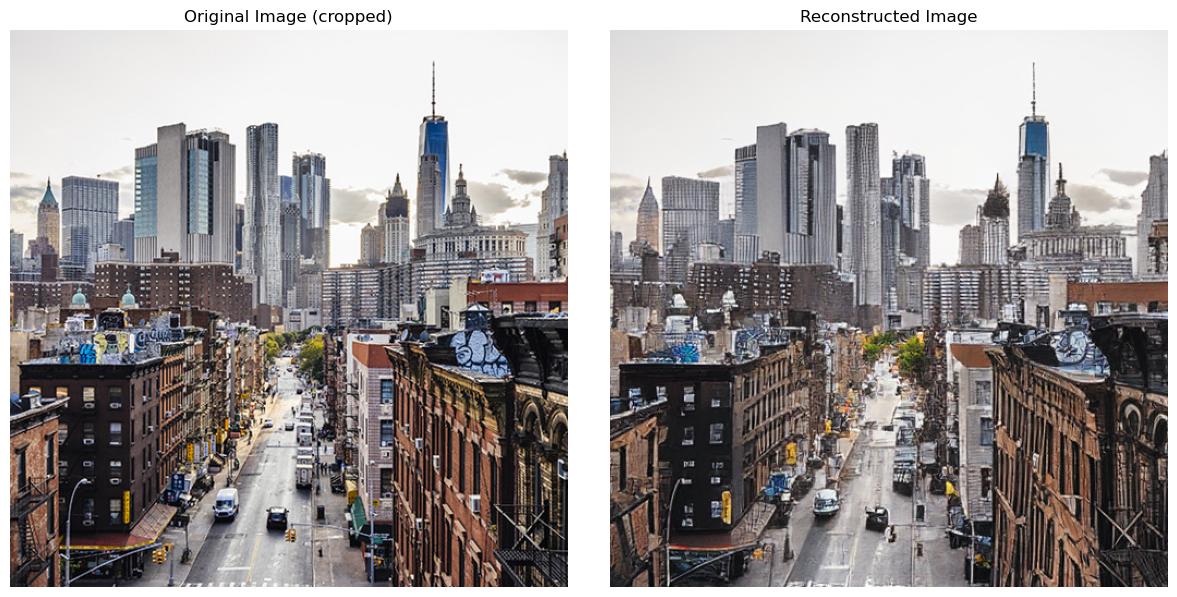

In [13]:
import matplotlib.pyplot as plt

original_image = Image.open(image_path).convert("RGB")
img = center_crop_arr(pil_image, image_size) #size에 맞게 변형
sample_image = Image.fromarray(sample)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

fig.tight_layout(pad=0)

# Display the original image
axs[0].imshow(img)
axs[0].set_title("Original Image (cropped)")
axs[0].axis('off')

# Display the reconstructed image
axs[1].imshow(sample_image)
axs[1].set_title("Reconstructed Image")
axs[1].axis('off')

plt.show()

In [14]:
#For Future purposes
import matplotlib.pyplot as plt
from invops.aug.mix import OperationTree

img = Image.open(image_path)

out = {"a" : 1, "b" : 2} #dictionary
out = tree(img, True)
fig, axs = plt.subplots(len(out), 2, figsize=(12, 6 * len(out)))
fig.tight_layout(pad=0)

def show_arr(arr: np.ndarray):
    if arr.dtype != np.uint8:
        arr = np.clip(arr, 0, 255).astype(np.uint8)
    image = Image.fromarray(arr)
    return image

for i, (key, value) in enumerate(out.items()):
    original_image = show_arr(value)
    sample_image = VQVAE_Output(original_image)
    # original image
    axs[i, 0].imshow(img)
    axs[i, 0].set_title("Original Image")
    axs[i, 0].axis('off')
    # sample image
    axs[i, 1].imshow(sample_image)
    axs[i, 1].set_title("Reconstructed Image")
    axs[i, 1].axis('off')

plt.show()

NameError: name 'tree' is not defined